In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

2024-04-21 07:08:22.812155: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 07:08:22.812282: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 07:08:22.932190: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 32
CHANNELS = 3
EPOCHS = 100

In [3]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/cifar10-all-original/cifar10_raw/images/train",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 60000 files belonging to 10 classes.


In [4]:
class_names = ds.class_names
class_names

['Airplane',
 'Automobile',
 'Bird',
 'Cat',
 'Deer',
 'Dog',
 'Frog',
 'Horse',
 'Ship',
 'Truck']

(32, 32, 32, 3)


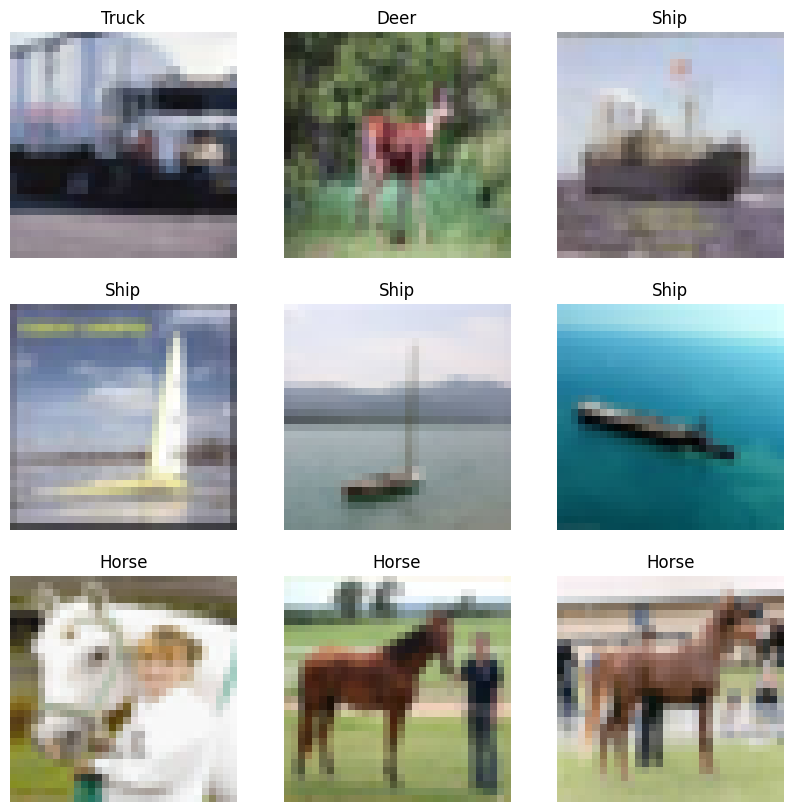

In [5]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in ds.take(1):
    print(image_batch.shape)
    for i in range(0,9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [6]:
len(ds)

1875

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(ds)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
from tensorflow.keras.layers import Resizing, Rescaling

resize_and_rescale = tf.keras.Sequential([
  Resizing(IMAGE_SIZE, IMAGE_SIZE),
  Rescaling(1./255),
])

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomContrast(0.2),
  layers.RandomZoom(0.2)
])

In [12]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# Build the model
model.build(input_shape=(None, *input_shape))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [13]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 1, 1, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,914 (671.54 KB)

 Trainable params: 171,914 (671.54 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 65s 14ms/step - accuracy: 0.1969 - loss: 2.0892 - val_accuracy: 0.3230 - val_loss: 1.8240
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.3321 - loss: 1.8060 - val_accuracy: 0.4073 - val_loss: 1.6196
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.3910 - loss: 1.6766 - val_accuracy: 0.4328 - val_loss: 1.5592
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4282 - loss: 1.5847 - val_accuracy: 0.4667 - val_loss: 1.4867
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4445 - loss: 1.5358 - val_accuracy: 0.4905 - val_loss: 1.4076
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4611 - loss: 1.4958 - val_accuracy: 0.4992 - val_loss: 1.3734
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4757 - loss: 1.4563 - val_accuracy: 0.5204 - val_loss: 1.3234
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4825 -

In [16]:
scores = model.evaluate(test_ds)

188/188 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.6534 - loss: 1.0482


In [17]:
scores

[1.0701223611831665, 0.6439494490623474]

In [18]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 1500}

In [19]:
history.history["loss"]

[1.9871785640716553,
 1.7716357707977295,
 1.6478360891342163,
 1.5794548988342285,
 1.524001121520996,
 1.4881560802459717,
 1.454481601715088,
 1.422480821609497,
 1.3946689367294312,
 1.3698419332504272,
 1.3458784818649292,
 1.332499623298645,
 1.3092231750488281,
 1.2979258298873901,
 1.285723328590393,
 1.271527886390686,
 1.257692575454712,
 1.2467941045761108,
 1.2378863096237183,
 1.2283074855804443,
 1.2164905071258545,
 1.2058229446411133,
 1.197835087776184,
 1.1924620866775513,
 1.1893973350524902,
 1.1818387508392334,
 1.1807920932769775,
 1.1747668981552124,
 1.1654194593429565,
 1.1619272232055664,
 1.1581252813339233,
 1.150496482849121,
 1.1499924659729004,
 1.1472445726394653,
 1.1382639408111572,
 1.133747935295105,
 1.123020052909851,
 1.1218804121017456,
 1.1200627088546753,
 1.1152065992355347,
 1.1082857847213745,
 1.104570746421814,
 1.1095012426376343,
 1.1047866344451904,
 1.0984185934066772,
 1.0909786224365234,
 1.0882477760314941,
 1.088719129562378,
 1.09

In [20]:
history.history["accuracy"]

[0.24572916328907013,
 0.3477708399295807,
 0.40181249380111694,
 0.42929166555404663,
 0.4491458237171173,
 0.46168750524520874,
 0.4754374921321869,
 0.48758333921432495,
 0.4984583258628845,
 0.5090416669845581,
 0.5166249871253967,
 0.5217499732971191,
 0.5293750166893005,
 0.5325833559036255,
 0.5415416955947876,
 0.5426666736602783,
 0.5508750081062317,
 0.5547083616256714,
 0.5578749775886536,
 0.5620625019073486,
 0.5653125047683716,
 0.5697916746139526,
 0.5735416412353516,
 0.5770416855812073,
 0.5773749947547913,
 0.5810208320617676,
 0.5831249952316284,
 0.581125020980835,
 0.5879999995231628,
 0.5877083539962769,
 0.5895416736602783,
 0.5911666750907898,
 0.5937291383743286,
 0.5944791436195374,
 0.597083330154419,
 0.5990208387374878,
 0.601312518119812,
 0.6030416488647461,
 0.604645848274231,
 0.6076874732971191,
 0.609416663646698,
 0.6082083582878113,
 0.6073333621025085,
 0.6086875200271606,
 0.6128333210945129,
 0.6165624856948853,
 0.6160416603088379,
 0.6129583120

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

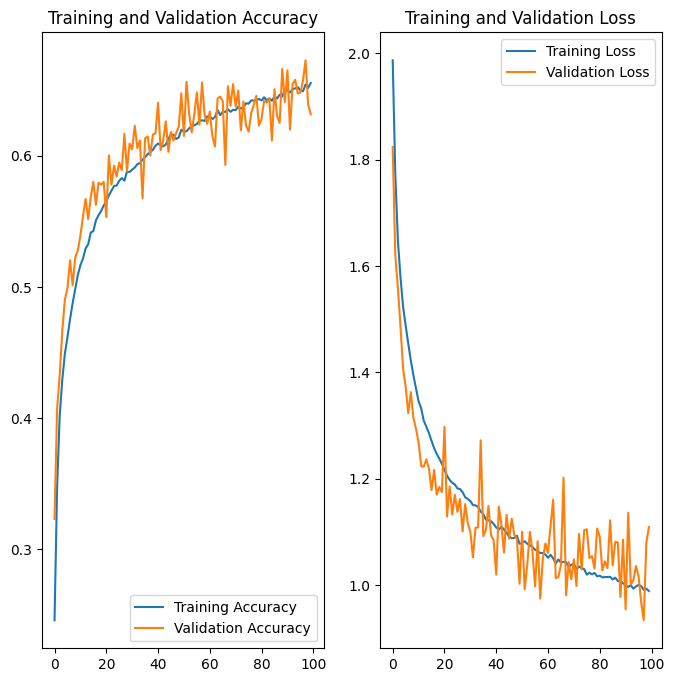

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()